# AerialWaste Dataset

In [1]:
# !wget https://zenodo.org/records/7991872/files/images0.zip -O images0.zip
# # !wget https://zenodo.org/records/7991872/files/images1.zip -O images1.zip
# # !wget https://zenodo.org/records/7991872/files/images2.zip -O images2.zip
# # !wget https://zenodo.org/records/7991872/files/images3.zip -O images3.zip
# # !wget https://zenodo.org/records/7991872/files/images4.zip -O images4.zip
# # !wget https://zenodo.org/records/7991872/files/images5.zip -O images5.zip
# # !wget https://zenodo.org/records/7991872/files/images6.zip -O images6.zip
!wget https://zenodo.org/records/7991872/files/testing.json -O testing.json
!wget https://zenodo.org/records/7991872/files/training.json -O training.json

--2024-05-12 08:02:16--  https://zenodo.org/records/7991872/files/testing.json
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1696233 (1.6M) [text/plain]
Saving to: 'testing.json'

testing.json        100%[===================>]   1.62M  1.14MB/s    in 1.4s    

2024-05-12 08:02:19 (1.14 MB/s) - 'testing.json' saved [1696233/1696233]

--2024-05-12 08:02:20--  https://zenodo.org/records/7991872/files/training.json
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3142168 (3.0M) [text/plain]
Saving to: 'training.json'

training.json       100%[===================>]   3.00M  1.42MB/s    in 2.1s    

2024-05-12 08:02:23 (1.42 MB/s) - 'training.json' saved [3

In [2]:
!pip install -qU wandb

In [3]:
import os, gc, sys, yaml, json, copy
from pathlib import Path
from collections import defaultdict
import glob
from tqdm.auto import tqdm

import math
import random
import numpy as np
import pandas as pd

import cv2
import PIL
import matplotlib.pyplot as plt

from sklearn import model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import utils
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler, WeightedRandomSampler
import torchvision.transforms as T
import albumentations as A
import albumentations.pytorch as pytorch
from typing import Any

import albumentations as A
from colorama import Fore

import warnings
warnings.filterwarnings("ignore")

In [4]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")
wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
#     tf.random.set_seed(SEED)
#     keras.utils.set_random_seed(seed=SEED)
    print('seeding done!!!')

def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

In [6]:
DATA_DIR = Path("/kaggle/input/aerial-dataset")
IMAGE_PATHS = glob.glob("/kaggle/input/aerial-dataset/*/*.png")

In [7]:
image_df = pd.DataFrame(IMAGE_PATHS, columns=['image_path'])

check_path = lambda path: os.path.exists(path)
get_image_dir = lambda path: int(Path(path).stem)
image_df['image_id'] = image_df['image_path'].map(get_image_dir)
image_df['exists'] = image_df['image_path'].map(check_path)
image_df['exists'].value_counts()

exists
True    10977
Name: count, dtype: int64

In [8]:
with open("/kaggle/working/testing.json", "r") as f:
    data = json.loads(f.read())

In [9]:
!pip install -qq pycocotools

# Info about dataset

**Binary labels**; these are given by `valid_fine_grain (0, 1)`

**Multi-class multi-label**; these are given by `severity 4, [0, 3]`

`evidence [0, 4]`

`site type`

```
{"id": --> the id of the iamge
"img_source": --> "GE", "AGEA" or "WV3"
"is_candidate_location":--> if this is a candidate location (1-positive) or not (0-negative)

"evidence": --> evidence perceived by the analyst at annotation time (from 0 to 3) [only if candidate location]
"severity": --> severity perceived by the analyst at annotation time (from 0 to 3) [only if candidate location]

"site type": --> type of site (e.g. production area) [only if candidate location]

"is_valid_fine_grain": --> if this image was analyzed to observe the Waste Objects or Storage modes present
"categories": --> which of the different Waste Objects or Storage Modes are present on the images [only if is_valid_fine_grained]
}
```

## Opening json files using pandas

The convention way of opening json files fails, therefore, its recommended to use `pandas.json_normalize(data, record_path)`

In [10]:
annot_df = pd.json_normalize(data, record_path=['annotations'])
annot_df.head()

,id,image_id,segmentation,category_id,DUBBI?,ADDED_BY_US?
0,254,662,"[[423.79211333333336, 471.2642266666667, 394.7...",17,NaN,NaN
1,255,662,"[[462.3606933333334, 461.3521066666666, 439.60...",17,NaN,NaN
2,256,662,"[[600.7421733333334, 480.77778, 601.67958, 492...",17,Yes,Yes
3,242,680,"[[131.44118666666668, 87.58145333333346, 124.0...",17,NaN,NaN
4,243,680,"[[261.33384, 128.20696666666663, 251.48986, 16...",17,NaN,NaN


In [11]:
segmentation_df = annot_df.merge(image_df, how='left', on='image_id')
segmentation_df

,id,image_id,segmentation,category_id,DUBBI?,ADDED_BY_US?,image_path,exists
0,254,662,"[[423.79211333333336, 471.2642266666667, 394.7...",17,NaN,NaN,/kaggle/input/aerial-dataset/images3/662.png,True
1,255,662,"[[462.3606933333334, 461.3521066666666, 439.60...",17,NaN,NaN,/kaggle/input/aerial-dataset/images3/662.png,True
2,256,662,"[[600.7421733333334, 480.77778, 601.67958, 492...",17,Yes,Yes,/kaggle/input/aerial-dataset/images3/662.png,True
3,242,680,"[[131.44118666666668, 87.58145333333346, 124.0...",17,NaN,NaN,/kaggle/input/aerial-dataset/images1/680.png,True
4,243,680,"[[261.33384, 128.20696666666663, 251.48986, 16...",17,NaN,NaN,/kaggle/input/aerial-dataset/images1/680.png,True
...,...,...,...,...,...,...,...,...
836,282,531,"[[567.2398733333334, 454.0075933333334, 592.43...",7,NaN,NaN,/kaggle/input/aerial-dataset/images3/531.png,True
837,283,531,"[[381.4532266666667, 440.89126666666664, 386.3...",20,NaN,NaN,/kaggle/input/aerial-dataset/images3/531.png,True
838,2504,531,"[[330.2385066666667, 448.58521999999994, 304.5...",20,NaN,NaN,/kaggle/input/aerial-dataset/images3/531.png,True
839,2505,2167,"[[457.5140266666667, 477.83853999999997, 485.0...",1,NaN,NaN,/kaggle/input/aerial-dataset/images2/2167.png,True


In [12]:
!mkdir /kaggle/working/masks

Image shape: (1051, 1051, 3)
Mask shape: (1051, 1051)


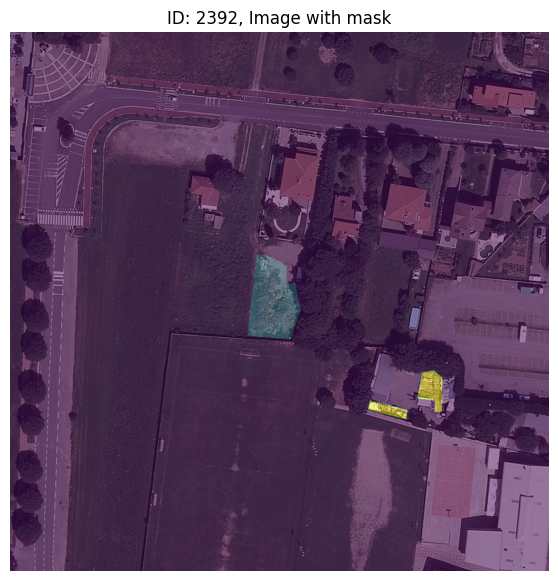

Image shape: (1051, 1051, 3)
Mask shape: (1051, 1051)


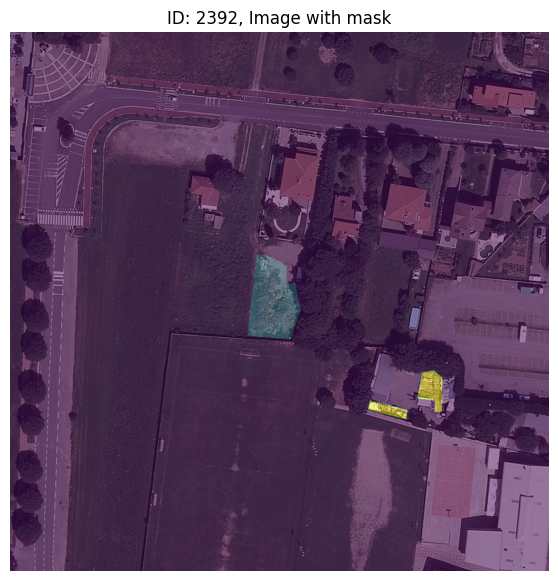

Image shape: (697, 697, 3)
Mask shape: (697, 697)


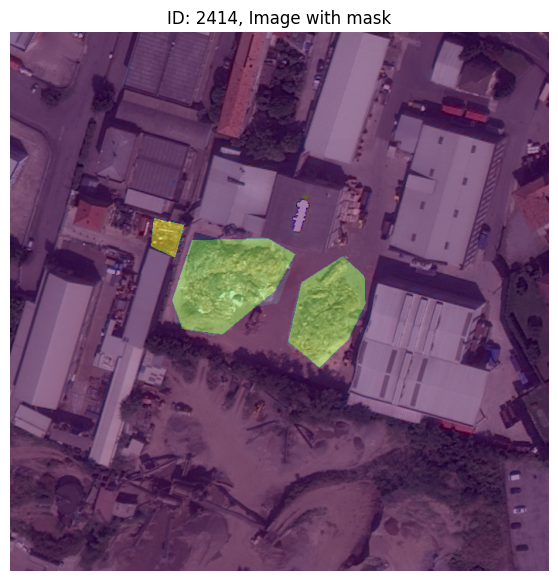

In [21]:
from pycocotools.coco import COCO

# Function to suppress print statements
def suppress_print(func, *args, **kwargs):
    with open(os.devnull, 'w') as f:
        original_stdout = sys.stdout
        sys.stdout = f
        try:
            return func(*args, **kwargs)
        finally:
            sys.stdout = original_stdout
        
def create_mask(img_path, json_dir):
    coco = suppress_print(COCO, json_dir)
    img_id = int(img_path.stem)
    img = coco.imgs[img_id]
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    
    mask = np.zeros((img['height'], img['width']), dtype=np.uint8)
    for ann in anns:
        ann_mask = coco.annToMask(ann)
        # Resize the annotation mask to match the image dimensions
        ann_mask_resized = np.array(PIL.Image.fromarray(ann_mask).resize((img['width'], img['height']), PIL.Image.NEAREST))
        mask = np.maximum(mask, ann_mask_resized * ann['category_id'])
        
    return mask
    

def imshow(df: pd.DataFrame, num: int = 3, show_mask: bool = True) -> None:
    for i in range(num):
        img_id = df.loc[i, 'image_id']
#         img_path = Path(f"/kaggle/working/images/{img_id}.png")
        img_path = df.loc[i, 'image_path']
        image = PIL.Image.open(img_path)
        mask = create_mask(Path(img_path), "/kaggle/working/testing.json")
        print(f"Image shape: {np.array(image).shape}")
        print(f"Mask shape: {mask.shape}")
        
        plt.figure(figsize=(7,7))
        plt.imshow(image)
        if show_mask:
            plt.imshow(mask, alpha=0.5)
        text = "with" if show_mask else "without"
        plt.title(f"ID: {img_id}, Image {text} mask")
        plt.axis('off')
        plt.savefig(f"{img_id}.png")
        plt.show()

IMAGE_PATHS = []
df = segmentation_df.iloc[550:560, :].reset_index()
imshow(df, num=3)
# len(IMAGE_PATHS)

**We use single-channel masks because its computationally advantageous and because our targets are 22 classes, which are represented as numbers from 0 to 22. So the masks are just a matrix with the values of each class in the corresponding pixels**

## Network Post processing

**Our task at the end of the training will be to obtain a tensor consisting of matrices. Each matrix belongs to one of the classes. The matrix class consists of the probabilities that each pixel of the picture belongs to this class. Next, we'll apply the argmax method, which will turn our tensor into a matrix, each value of which will be the index of the class with the highest probability**

## Transform Pipeline Module

**We only have 871 pictures. This is extremely small for the segmentation of 23 classes. To solve this problem, augment the pictures. To get better result, need more experimentation**

    1. height - image height
    
    2. width - image width
    
    3. cut - the number of random cuts of parts of the picture
    
    4. defocus - image defocus
    
    5. dropout_pieces - parts of the picture falling out
    
    6. dropout_pixel - grainy dropout of pixels in the picture
    
    7. horizontal_lines - add horizontal line effects
    
    8. vertical_lines - add vertical line effects
    
    9. spatial - add spatial transformations (perspective, angle)
    
    10. rain - add rain and cloudy weather
    
    11. sunny - add highlights and sunshine
    
    12. snow - add snowfall
    
    13. foggy - add fog

In [14]:
class TransformPipelineModule:
    """
    This high-level API manages the transformation pipeline
    Includes dynamic adjustment of conversion parameters based on the size of the input image.
    The ratio size of the input image to the desired output signal size calculated,
     and then the conversion parameters adjusted accordingly.
    """
    def __init__(self,
                 height: int,
                 width: int,
                 cut: int = 0,
                 defocus: bool = False,
                 pixel_dropout: bool = False,
                 pieces_dropout: bool = False,
                 horizontal_lines: bool = False,
                 vertical_lines: bool = False,
                 spatial: bool = True,
                 rain: bool = True,
                 sunny: bool = True,
                 snow: bool = True,
                 foggy: bool = True):

        # Customization options.
        self.height = height
        self.width = width
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        # Image tearing.
        self.defocus = defocus
        self.pixel_dropout = pixel_dropout
        self.pieces_dropout = pieces_dropout
        self.horizontal_lines = horizontal_lines
        self.vertical_lines = vertical_lines
        self.__damage = any([self.defocus, self.pieces_dropout,
                             self.pieces_dropout, self.horizontal_lines,
                             self.vertical_lines])

        self._defocus_transform = None
        self._pixel_dropout_transform = None
        self._pieces_dropout_transform = None
        self._horizontal_lines_transform = None
        self._vertical_lines_transform = None

        # Weather changes.
        self.rain = rain
        self.sunny = sunny
        self.snow = snow
        self.foggy = foggy
        self.__weather = any([self.rain, self.sunny,
                              self.snow, self.foggy])

        self._rain_transform = None
        self._sunny_transform = None
        self._snow_transform = None
        self._foggy_transform = None

        # Standard transforms.
        self.cut = cut
        self.spatial = spatial

        self._cut_transforms = None
        self._spatial_transforms = None
        self._base_transforms = None

        self.__debug_state = None

    def __str__(self) -> str:
        return self.__class__.__name__

    def __repr__(self) -> str:
        return f"{self.__class__}: {self.__dict__}"

    def __len__(self) -> int:
        # Returns the number blocks in the pipeline.
        return sum([
            int(value)
            for value in self.__dict__.values()
            if type(value) is bool
        ])

    def __activate_debugging(self,
                             image: np.array,
                             mask: np.array
                            ) -> tuple:
        """
        Activates the debugging mode.
        Transforms the image without translation into tensors.
        """

        transform = A.Resize(height=self.height, width=self.width,
                             interpolation=cv2.INTER_LINEAR)
        transformed = transform(image=image, mask=mask)
        image, mask = transformed["image"], transformed["mask"]

        if not self.__debug_state:
            print(Fore.YELLOW+f"|| Debugging mode activated ||"+Fore.WHITE)
            self.__debug_state = True
        return image, mask

    def __weather_adaptation(self) -> None:
        """
        Creates weather effects.
        Namely: rain, sunny, snow, fog.
        """

        # Rain effects.
        if self.rain:
            self._rain_transform = A.RandomRain(
                slant_lower=-10,
                slant_upper=10,
                drop_length=15,
                drop_width=1,
                drop_color=(200, 200, 200),
                blur_value=12,
                brightness_coefficient=0.52,
                rain_type="heavy",
                p=0.25)

        # Sunny effects.
        if self.sunny:
            self._sunny_transform = A.RandomSunFlare(
                flare_roi=(0, 0, 1, 1),
                angle_lower=0,
                angle_upper=1,
                num_flare_circles_lower=4,
                num_flare_circles_upper=8,
                src_radius=100,
                src_color=(255, 255, 255),
                p=0.25)

        # Snow effects.
        if self.snow:
            self._snow_transform = A.RandomSnow(
                snow_point_lower=0.1,
                snow_point_upper=0.3,
                brightness_coeff=2.5,
                p=0.25)

        # Fog effects.
        if self.foggy:
            self._foggy_transform = A.RandomFog(
                fog_coef_lower=0.3,
                fog_coef_upper=0.4,
                alpha_coef=0.1,
                p=0.01)

    def __damage_adaptation(self) -> None:
        """
        Creates image corruption effects.
        Namely: defocus, pixel dropout, vertical stripes, horizontal stripes, loss parts of the image.
        """

        # defocus.
        if self.defocus:
            self._defocus_transform = A.Defocus(
                radius=(0.5, 2.5),
                alias_blur=(0.1, 0.5),
                p=0.05)

        # pixel dropout.
        if self.pixel_dropout:
            self._pixel_dropout_transform = A.PixelDropout(dropout_prob=0.01, p=0.05)

        # loss parts of the image.
        if self.pieces_dropout:
            self._pieces_dropout_transform = A.CoarseDropout(
                max_holes=50,
                max_height=512,
                max_width=2,
                min_holes=10,
                min_height=128,
                min_width=1,
                fill_value=0,
                mask_fill_value=None,
                p=0.05)

        # horizontal stripes.
        if self.horizontal_lines:
            self._horizontal_lines_transform = A.CoarseDropout(
                max_holes=50,
                max_height=2,
                max_width=512,
                min_holes=10,
                min_height=1,
                min_width=128,
                fill_value=0,
                mask_fill_value=None,
                p=0.05)

        # vertical stripes.
        if self.vertical_lines:
            self._vertical_lines_transform = A.CoarseDropout(
                max_holes=50,
                max_height=8,
                max_width=8,
                min_holes=10,
                min_height=2,
                min_width=2,
                fill_value=0,
                mask_fill_value=None,
                p=0.05)

    def __cut_adaptation(self) -> None:
        # Includes three blocks: single, double and triple slice.
        # Single cut of the image.
        if self.cut == 1:
            self._cut_transforms = A.Compose([
                A.RandomCrop(width=2667, height=4000, p=0.15)
                ])

        # Double cut the image.
        elif self.cut == 2:
            self._cut_transforms = A.Compose([
                A.RandomCrop(width=2667, height=4000, p=0.10),
                A.RandomCrop(width=1283, height=2000, p=0.05),
            ])

        # Triple cut the image.
        else:
            self._cut_transforms = A.Compose([
                A.RandomCrop(width=2667, height=4000, p=0.15),
                A.RandomCrop(width=1283, height=2000, p=0.10),
                A.RandomCrop(width=855, height=1333, p=0.05),
            ])

    def __spatial_adaptation(self) -> None:
        """
        Spatial transformations.
        Namely: horizontal flip, vertical flip, affine, perspective.
        """

        if self.spatial:
            self._spatial_transforms = A.Compose([
                # horizontal flip.
                A.HorizontalFlip(p=0.5),

                # vertical flip.
                A.VerticalFlip(p=0.5),

                # affine.
                A.Affine(
                    rotate=[-15, 15], p=0.35,
                    mode=cv2.BORDER_REFLECT,
                    interpolation=cv2.INTER_LINEAR),

                # perspective.
                A.Perspective(
                    scale=(0.05, 0.25),
                    pad_mode=cv2.BORDER_REFLECT,
                    interpolation=cv2.INTER_LINEAR,
                    p=1)
            ])

    def __base_transform_adaptation(self) -> None:
        """
        A must-have composition.
        Translates the image into tensors.
        Normalizes tensors.
        Resizes.
        """

        self._base_transforms = A.Compose([
            A.Resize(height=self.height, width=self.width),
            A.Normalize(
                mean=self.mean,
                std=self.std,
            ),
            pytorch.ToTensorV2()
        ])

    def __pipeline_adaptation(self) -> None:
        """
        Causes transformation pipeline modules to adapt.
        Verifies that modules participate in the pipeline.
        """

        if self.__damage:
            self.__damage_adaptation()
        if self.__weather:
            self.__weather_adaptation()
        if self.cut:
            self.__cut_adaptation()
        if self.spatial:
            self.__spatial_adaptation()
        self.__base_transform_adaptation()

    def __call__(self, image: np.array, mask: np.array,
                 debug_mode: bool = False):
        self.__pipeline_adaptation()

        # Weather transformations.
        # Rain
        if self._rain_transform:
            transformed = self._rain_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Sunny.
        if self._sunny_transform:
            transformed = self._sunny_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Snow.
        if self._snow_transform:
            transformed = self._snow_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Foggy.
        if self._foggy_transform:
            transformed = self._foggy_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Damage transformation
        # Defocus.
        if self._defocus_transform:
            transformed = self._defocus_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Pixel dropout.
        if self._pixel_dropout_transform:
            transformed = self._pixel_dropout_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Pieces dropout.
        if self._pieces_dropout_transform:
            transformed = self._pieces_dropout_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Horizontal lines.
        if self._horizontal_lines_transform:
            transformed = self._horizontal_lines_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Vertical lines.
        if self._vertical_lines_transform:
            transformed = self._vertical_lines_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Cut transformation.
        if self.cut:
            transformed = self._cut_transforms(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Spatial transformation.
        if self.spatial:
            transformed = self._spatial_transforms(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Mandatory Transformations for Learning
        if not debug_mode:
            transformed = self._base_transforms(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        else:
            image, mask = self.__activate_debugging(image=image, mask=mask)

        return {"image": image,
                "mask": mask}

# Creating dataset

In [15]:
class AerialWasteDataset(utils.data.Dataset):
    def __init__(self, data: pd.DataFrame, json_dir, transforms=None):
        self.data = data
        self.json_dir = json_dir
        self.tsfm = transforms
        
    @staticmethod
    def __type_checking(self, 
                        data: pd.DataFrame, 
                        json_dir: str):
        assert isinstance(data, pd.DataFrame)
        assert isinstance(json_dir, str)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_id = self.data.loc[idx, 'image_id']
        img_path = self.data.loc[idx, 'image_path']
        assert os.path.exists(img_path)
        image = PIL.Image.open(img_path)
        image = np.array(image)[:,:,::-1]
        mask = create_mask(Path(img_path), self.json_dir)
        transformed = self.tsfm(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']
        
        return {"image": image, "mask": mask}
    

# ts = A.Compose([
#             A.Resize(height=640, width=640),
#             A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
#             A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
#             A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    
#             A.OneOf([
#                 A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=1),
#                 A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1),
#                 A.RandomFog(fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1, p=1),
#             ], p=0.3),
    
#             A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=0.2),
#             A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=0.2),
    
#             A.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225]),
#             pytorch.ToTensorV2()
#         ])

# ts = TransformPipelineModule(height=1024, width=1024)

def get_transforms(height, width):
    train_tsfm = A.Compose([
        A.Resize(height=height, width=width),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.OneOf([
            A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=1),
            A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1),
            A.RandomFog(fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1, p=1),
        ], p=0.3),

        A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=0.2),
        A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=0.2),
        A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=0.2),
        A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225]),
        pytorch.ToTensorV2()
    ])
    
    valid_tsfm = A.Compose([
        A.Resize(height=height, width=width),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225]),
        pytorch.ToTensorV2()
    ])
    return {"train": train_tsfm, "eval": valid_tsfm}


def get_dataloaders(data, cfg, split="train"):
    img_size = cfg['img_size']
    height, width = img_size[0], img_size[1]
    tsfm = get_transforms(height=height, width=width)
    if split == 'train':
        tr_tsfm = tsfm['train']
        ds = AerialWasteDataset(data, "/kaggle/working/testing.json", tr_tsfm)
        dls = utils.data.DataLoader(ds, 
                                    batch_size=cfg['batch_size'], 
                                    shuffle=True, 
                                    num_workers=0, 
                                    drop_last=True, 
                                    pin_memory=True)
        
    elif split == 'valid' or split == 'test':
        eval_tsfm = tsfm['eval']
        ds = AerialWasteDataset(data, "/kaggle/working/testing.json", eval_tsfm)
        dls = utils.data.DataLoader(ds, 
                                    batch_size=cfg['batch_size'], 
                                    shuffle=False, 
                                    num_workers=0, 
                                    drop_last=False, 
                                    pin_memory=True)
    else:
        raise Exception("Split should be 'train' or 'valid' or 'test'!!!")
    return dls


# ds = AerialWasteDataset(segmentation_df, "/kaggle/working/testing.json", ts)

# def show_image_mask(sample):
#     image, mask = sample['image'], sample['mask']
#     plt.figure(figsize=(10,10))
#     plt.subplot(131)
#     plt.title("image")
#     plt.imshow(image.permute(1,2,0))
#     plt.axis("off")

#     plt.subplot(132)
#     plt.title("mask")
#     plt.imshow(mask.squeeze())
#     plt.axis("off")

#     plt.subplot(133)
#     plt.title("image with mask")
#     plt.imshow(image.permute(1,2,0))
#     plt.imshow(mask.squeeze(), alpha=0.5)
#     plt.axis("off");
    
# sample = ds[400]
# show_image_mask(sample)

In [16]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.tsfm = A.Compose([t for t in dataset.tsfm if not isinstance(t, (A.Normalize, pytorch.ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=3, figsize=(10, 24))
    for i in range(samples):
        transformed = dataset[idx]
        image, mask = transformed['image'], transformed['mask']
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 2].imshow(image)
        ax[i, 2].imshow(mask, alpha=0.5)
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 2].set_title("Overlay mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
        
    plt.tight_layout()
    plt.show()

In [17]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    
def visualize_mini_batches(batch, predicted_masks):
    for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], predicted_masks):
        plt.figure(figsize=(5, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1,2,0).detach().cpu().numpy())  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.detach().cpu().numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.detach().cpu().numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

# Dice Loss

In [18]:
import torch
from torch.nn.modules.loss import _Loss

class DiceLoss(_Loss):
    def __init__(self, mode='multiclass', classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-07):
        super(DiceLoss, self).__init__()
        self.mode = mode
        self.classes = classes
        self.log_loss = log_loss
        self.from_logits = from_logits
        self.smooth = smooth
        self.ignore_index = ignore_index
        self.eps = eps

    def forward(self, y_pred, y_true):
        # Ensure the predicted tensor is activated
        y_pred = torch.sigmoid(y_pred) if self.mode == 'binary' else torch.softmax(y_pred, dim=1)
        
        # For multiclass, use argmax to get the class prediction
        if self.mode == 'multiclass':
            y_pred = torch.argmax(y_pred, dim=1)
        
        # Flatten the tensors
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        
        # Ensure tensors are the same size
        if y_pred.size(0) != y_true.size(0):
            raise RuntimeError(f'The size of tensor y_pred ({y_pred.size(0)}) must match the size of tensor y_true ({y_true.size(0)})')
        
        # Calculate Dice coefficient
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        
        # Calculate Dice loss
        dice_loss = 1 - dice
        
        return dice_loss

In [19]:
!pip install -q segmentation-models-pytorch torchmetrics
# !pip install -qU pytorch-lightning

In [20]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

import pytorch_lightning as pl
from torchmetrics import Accuracy, JaccardIndex, FBetaScore
from typing import Any, Union

In [21]:
PARAMS = {
    "device": torch.device("cuda") if torch.cuda.is_available() else "cpu",
    "encoder": "resnext50_32x4d",
    "encoder_weights": "imagenet",
    "num_classes": 22,
    "in_channels": 3,
    "batch_size": 4,
    "num_workers": 0,
    "epochs": 100,
    "lr": 3e-4,
    "img_size": [512, 512],
    "seed": 2024,
}

METRICS = {
    "accuracy": Accuracy(task="multiclass",
                        threshold=0.5,
                        num_classes=PARAMS['num_classes'],
                        validate_args=True,
                        ignore_index=None,
                        average="micro").to(PARAMS['device']),
    
    "jaccard_index": JaccardIndex(task="multiclass",
                                 threshold=0.5,
                                 num_classes=PARAMS['num_classes'],
                                 validate_args=True,
                                 ignore_index=None,
                                 average="macro").to(PARAMS['device']),
    
    "fbeta_score": FBetaScore(task="multiclass",
                              beta=1.0, 
                              threshold=0.5, 
                              num_classes=PARAMS['num_classes'], 
                              validate_args=True, 
                              ignore_index=None, 
                              average="micro").to(PARAMS['device'])
}

def train(train_loader, model, criterion, optimizer, epoch, scaler, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    for i, batch in enumerate(stream, start=1):
        optimizer.zero_grad(set_to_none=True)
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            images, target = batch['image'], batch['mask']
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)

            logits = model.forward(images.to(torch.float32))
            activated = F.softmax(input=logits, dim=1)
            predictions = torch.argmax(activated, dim=1)
            loss = criterion(logits, target.to(torch.int64))
        
        accuracy = METRICS['accuracy'](predictions, target)
        jaccard = METRICS['jaccard_index'](predictions, target)
        fbeta = METRICS['fbeta_score'](predictions, target)
        
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        metric_monitor.update("Jaccard", jaccard)
        metric_monitor.update("FBeta", fbeta)
        
        train_loss += loss.detach().float()
        _train_metrics = {
            "train/batch_loss": loss.item(),
            "train/accuracy": accuracy,
            "train/jaccard_index": jaccard,
            "train/fbeta_score": fbeta
        }
        
        if (i+1) % 50 == 0:
            wandb.log(_train_metrics)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
        
    total_train_loss = train_loss / len(train_loader)
    
    flush()
    return _train_metrics, total_train_loss
        
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    valid_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(stream, start=1):
            images, target = batch['image'], batch['mask']
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)

            logits = model.forward(images.to(torch.float32))
            activated = F.softmax(input=logits, dim=1)
            predictions = torch.argmax(activated, dim=1)
            loss = criterion(logits, target.to(torch.int64))
            
            accuracy = METRICS['accuracy'](predictions, target)
            jaccard = METRICS['jaccard_index'](predictions, target)
            fbeta = METRICS['fbeta_score'](predictions, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            metric_monitor.update("Jaccard", jaccard)
            metric_monitor.update("FBeta", fbeta)
            
            valid_loss += loss.detach().float()
            _valid_metrics = {
                "valid/batch_loss": loss.item(),
#                 "valid/loss": valid_loss,
                "valid/accuracy": accuracy,
                "valid/jaccard_index": jaccard,
                "valid/fbeta_score": fbeta
            }

            if (i+1) % 10 == 0:
                wandb.log(_valid_metrics)
            
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            
        if epoch%9 == 0:
            print(f"##### Visualizing mini batches at epoch {epoch} ####")
            visualize_mini_batches(batch, predictions)
    flush()
    total_valid_loss = valid_loss / len(val_loader)
    return _valid_metrics, total_valid_loss
    
seeding(PARAMS['seed'])

seeding done!!!


In [22]:
def create_model(params):
    model = smp.DeepLabV3Plus(
        encoder_name=params['encoder'],
        encoder_weights=params['encoder_weights'],
        in_channels=params['in_channels'],
        classes=params['num_classes'],
        activation=None
    )
    return model.to(params['device'])

In [23]:
train_data, valid_data = model_selection.train_test_split(segmentation_df, test_size=0.2, shuffle=True, random_state=42)
train_data.reset_index(drop=True, inplace=True), valid_data.reset_index(drop=True, inplace=True)

(None, None)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 219MB/s] 
wandb: Currently logged in as: samu2505. Use `wandb login --relogin` to force relogin


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (inf --> 0.248478). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.248478 --> 0.212724). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.212724 --> 0.173263). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.173263 --> 0.136852). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.136852 --> 0.122709). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.122709 --> 0.114490). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.114490 --> 0.112436). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

##### Visualizing mini batches at epoch 9 ####


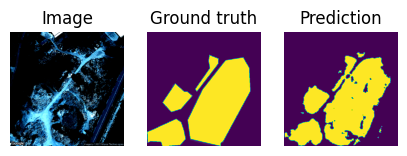

Best metric: (0.112436 --> 0.093630). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.093630 --> 0.088707). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.088707 --> 0.073220). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.073220 --> 0.065129). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Best metric: (0.065129 --> 0.064044). Saving model ...


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

##### Visualizing mini batches at epoch 18 ####


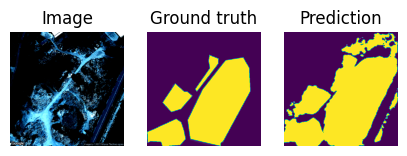

  0%|          | 0/168 [00:00<?, ?it/s]

In [ ]:
def train_and_validate(model, train_dataset, val_dataset, params):
    run = wandb.init(
        project="AerialWasteSegmentation"
    )
    artifact = wandb.Artifact("aerialwaste_segmentation_weights", type="model")
    
    train_loader = get_dataloaders(train_dataset, cfg=params, split='train')
    val_loader = get_dataloaders(val_dataset, cfg=params, split='valid')
    
    criterion = nn.CrossEntropyLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    scaler = torch.cuda.amp.GradScaler()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                     params['epochs'], 
                                                                     eta_min=0.01*params['epochs'])
    best_metric = np.inf
    loss_min = np.inf
    es = 0
    ES_RATIO = 0.25 if params['epochs'] < 10 else 0.20
    seg_weights_file = "aerialwaste_segmentation.pth"
    for epoch in range(1, params["epochs"] + 1):
#         scheduler.step(epoch-1)
        _train_metrics, train_loss = train(train_loader, model, criterion, optimizer, epoch, scaler, params)
        _valid_metrics, val_loss = validate(val_loader, model, criterion, epoch, params)
        
        _train_metrics["train/loss"] = train_loss
        _valid_metrics["valid/loss"] = val_loss
        wandb.log({**_train_metrics, **_valid_metrics})
        if val_loss < best_metric:
            print(f"Best metric: ({best_metric:.6f} --> {val_loss:.6f}). Saving model ...")
#             torch.save(model.module.state_dict(), f"{name}_fold_{fold}.pth")
            torch.save(model.state_dict(), seg_weights_file)
            best_metric = val_loss
            es = 0
        else:
            es += 1
            
        if es > math.ceil(ES_RATIO*params['epochs']):
            print(f"Early stopping on epoch {epoch} ...")
            break
            
    wandb.config = params
    artifact.add_file(seg_weights_file)
    run.log_artifact(artifact)
    wandb.finish()
    flush()


model = create_model(PARAMS)
train_and_validate(model, train_data, valid_data, PARAMS)

## Best hyperparameters and encoders

```

Unet(encoder='resnext50_32x4d')

loss = CrossEntropy

lr = 3e-4

```

# Inference

In [ ]:
# dls = get_dataloaders(valid_data, cfg=PARAMS, split='valid')

In [ ]:
# batch = next(iter(dls))
# with torch.no_grad():
#     model.eval()
#     logits = model(batch["image"].to(PARAMS['device']))
# activated = F.softmax(logits, dim=1)
# pr_masks = torch.argmax(activated, dim=1)

# visualize_mini_batches(batch, pr_masks)

In [ ]:
# loss_fn = DiceLoss(mode='multiclass').to('cuda')
# loss_fn(logits, batch['mask'].to('cuda'))
# # # logits.shape, batch['mask'].shape
# # # help(smp.losses)

# Aerial Dataset Data Module

In [ ]:
# import pytorch_lightning as pl
# from torch.utils.data import DataLoader
# import albumentations as A
# import torchvision.transforms as T
# import albumentations.pytorch as pytorch
# from typing import Union

In [ ]:
# class AerialDataModule(pl.LightningDataModule):
#     def __init__(self, 
#                  data: pd.DataFrame, 
#                  json_dir: str, 
#                  transforms: Union[T.Compose, A.Compose],
#                  batch_size: int = 4, 
#                  num_workers: int = 4,
#                 ):
#         super().__init__()
#         self.data = data
#         self.json_dir = json_dir
#         self.tsfm = transforms
#         self.batch_size = batch_size
#         self.num_workers = num_workers
#         self.mean = [0.485, 0.456, 0.406]
#         self.std = [0.229, 0.224, 0.225]
        
#         self.data_train = None
#         self.data_val = None
#         self.data_test = None
#         self.data_predict = None
        
#         self.eval_transform = A.Compose([
#             A.Resize(height=transforms.height,
#                      width=transforms.width),
#             A.Normalize(mean=self.mean,
#                         std=self.std),
#             pytorch.ToTensorV2()
#         ])
        
        
#     def setup(self, stage: str = None) -> None:
#         self.data_train = AerialWasteDataset(self.data, self.json_dir, self.eval_transform)
#         self.data_val = AerialWasteDataset(self.data, self.json_dir, self.eval_transform)
#         self.data_test = AerialWasteDataset(self.data, self.json_dir, self.eval_transform)
#         self.data_predict = AerialWasteDataset(self.data, self.json_dir, self.eval_transform)
        
        
#     def train_dataloader(self) -> DataLoader:
#         return DataLoader(
#             self.data_train,
#             batch_size=self.batch_size,
#             num_workers=self.num_workers,
#             shuffle=True
#         )
    
#     def val_dataloader(self) -> DataLoader:
#         return DataLoader(
#             self.data_val,
#             batch_size=self.batch_size,
#             num_workers=self.num_workers,
#             shuffle=False
#         )
    
    
#     def test_dataloader(self) -> DataLoader:
#         return DataLoader(
#             self.data_test,
#             batch_size=self.batch_size,
#             num_workers=self.num_workers,
#             shuffle=False
#         )
    
    
#     def predict_dataloader(self) -> DataLoader:
#         return DataLoader(
#             self.data_predict,
#             batch_size=self.batch_size,
#             num_workers=self.num_workers,
#             shuffle=False
#         )

In [ ]:
# batch['image'].min(), batch['mask'].ndim

In [ ]:
# class AerialModel(pl.LightningModule):

#     def __init__(self, 
#                  model: nn.Module, 
#                  example_input_array: Union[list, tuple], 
#                  optim_dict: dict = None,
#                  lr: float = None, 
#                  num_classes: int = 22):
#         super().__init__()
#         self.save_hyperparameters()
#         self.example_input_array = torch.zeros(size=example_input_array)
#         self.num_classes = num_classes
#         self.model = model
#         self.criterion = nn.CrossEntropyLoss()
#         self.optim_dict = optim_dict
#         self._device = "cuda" if torch.cuda.is_available else "cpu"
        
#         self.step_outputs = {
#             "loss": [],
#             "accuracy": [],
#             "jaccard_index": [],
#             "fbeta_score": [],
#         }
        
#         self.metrics = {
#             "accuracy": Accuracy(task="multiclass",
#                                  threshold=0.5,
#                                  num_classes=num_classes,
#                                  validate_args=True,
#                                  ignore_index=None,
#                                  average="micro").to(self._device),

#             "jaccard_index": JaccardIndex(task="multiclass",
#                                           threshold=0.5,
#                                           num_classes=num_classes,
#                                           validate_args=True,
#                                           ignore_index=None,
#                                           average="macro").to(self._device),

#             "fbeta_score": FBetaScore(task="multiclass",
#                                       beta=1.0,
#                                       threshold=0.5,
#                                       num_classes=num_classes,
#                                       average="micro",
#                                       ignore_index=None,
#                                       validate_args=True).to(self._device)
#         }
        
        
# #         self.model = smp.create_model(
# #             arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
# #         )

# #         # preprocessing parameteres for image
# #         params = smp.encoders.get_preprocessing_params(encoder_name)
# #         self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
# #         self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

# #         # for image segmentation dice loss could be the best first choice
# #         self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
# #         self.step_outputs = []

#     def forward(self, image):
#         # normalize image here
# #         image = (image - self.mean) / self.std
#         mask = self.model(image)
#         return mask

#     def shared_step(self, batch, stage: str) -> torch.Tensor:
#         image = batch["image"]
#         mask = batch["mask"]
#         assert image.ndim == 4
#         assert image.max() <= 3 and image.min() >= -3
#         assert mask.ndim == 3
#         assert mask.max() <= 22 and mask.min() >= 0

#         logits = self.forward(image.to(torch.float32))
#         activated = F.softmax(input=logits, dim=1)
#         predictions = torch.argmax(activated, dim=1)
#         loss = self.criterion(logits, mask.to(torch.int64))

#         accuracy = self.metrics["accuracy"](predictions, mask)
#         jaccard_index = self.metrics["jaccard_index"](predictions, mask)
#         fbeta_score = self.metrics["fbeta_score"](predictions, mask)
        
#         self.step_outputs["loss"].append(loss)
#         self.step_outputs["accuracy"].append(accuracy)
#         self.step_outputs["jaccard_index"].append(jaccard_index)
#         self.step_outputs["fbeta_score"].append(fbeta_score)
        
#         return loss

#     def shared_epoch_end(self, stage: Any):
#         loss = torch.mean(torch.tensor([
#             loss for loss in self.step_outputs['loss']
#         ]))
        
#         accuracy = torch.mean(torch.tensor([
#             accuracy for accuracy in self.step_outputs["accuracy"]
#         ]))

#         jaccard_index = torch.mean(torch.tensor([
#             jaccard_index for jaccard_index in self.step_outputs["jaccard_index"]
#         ]))

#         fbeta_score = torch.mean(torch.tensor(
#             [fbeta_score for fbeta_score in self.step_outputs["fbeta_score"]
#              ]))
        
#         for key in self.step_outputs.keys():
#             self.step_outputs[key].clear()

#         metrics = {
#             f"{stage}_loss": loss,
#             f"{stage}_accuracy": accuracy,
#             f"{stage}_jaccard_index": jaccard_index,
#             f"{stage}_fbeta_score": fbeta_score
#         }
#         self.log_dict(metrics, prog_bar=True)

#     def training_step(self, batch: Any, batch_idx: Any):
#         return self.shared_step(batch, "train")            

#     def on_train_epoch_end(self) -> None:
#         return self.shared_epoch_end(stage="train")

#     def validation_step(self, batch: Any, batch_idx: Any):
#         return self.shared_step(batch, stage="valid")

#     def on_validation_epoch_end(self) -> None:
#         return self.shared_epoch_end(stage="valid")
# #         self.step_outputs.clear()

#     def test_step(self, batch: Any, batch_idx: Any):
#         return self.shared_step(batch, stage="test")  

#     def on_test_epoch_end(self):
#         self.shared_epoch_end("test")
# #         self.step_outputs.clear()
#     def predict_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0):
#         image, mask = batch['image'], batch['mask']
#         assert image.ndim == 4
#         assert image.max() <= 3 and image.min() >= -3
#         assert mask.ndim == 3
#         assert mask.max() <= 22 and mask.min() >= 0

#         logits_mask = self.forward(image.to(torch.float32))
#         activated = F.softmax(input=logits_mask, dim=1)
#         predictions = torch.argmax(activated, dim=1)
#         return predictions

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(
#             params=self.parameters(),
#             lr=self.hparams.lr
#         )
        
#         scheduler_dict = {
#             "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
#                 optimizer=optimizer,
#                 patience=5
#             ),
#             "interval": "epoch",
#             "monitor": "val_loss"
#         }

#         optimization_dictionary = {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
        
#         return self.optim_dict if self.optim_dict else optimization_dictionary

In [ ]:
# from pytorch_lightning.callbacks import ModelCheckpoint
# from pytorch_lightning.callbacks import EarlyStopping
# from pytorch_lightning.callbacks import LearningRateMonitor
# from pytorch_lightning.loggers import TensorBoardLogger
# import pytorch_lightning as pl
# import torch
# import segmentation_models_pytorch as smp
# import warnings
# from typing import Union, Any
# from colorama import Fore

In [ ]:
# def main(callbacks: list,
#          model: Union[list, tuple],
#          logger: TensorBoardLogger,
# #          data_path: str,
# #          target_path: str,
#          example_input_array: Union[list, tuple],
#          optim_dict: dict = None,
#          transforms_dict: dict = None,
#          ) -> None:

#     # Trainer
#     trainer = pl.Trainer(
#         fast_dev_run=False,
#         accelerator="auto",
#         strategy="auto",
#         devices="auto",
#         num_nodes=1,
#         logger=logger,
#         callbacks=callbacks,
#         max_epochs=80,
#         min_epochs=35
#     )

#     # Transforms Module
#     if not transforms_dict:
#         transforms = TransformPipelineModule(
#             height=704,
#             width=1056,
#             cut=0,
#             defocus=True,
#             pixel_dropout=False,
#             pieces_dropout=False,
#             horizontal_lines=False,
#             vertical_lines=False,
#             spatial=True,
#             rain=True,
#             sunny=True,
#             snow=False,
#             foggy=False
#         )
#     else:
#         transforms = TransformPipelineModule(
#             **transforms_dict
#         )

#     # Datamodule
#     datamodule = AerialDataModule(
#         annot_df, "/kaggle/working/testing.json", transforms
#     )
# #     datamodule = PhotopicVisionDataModule(
# #         target_path=target_path,
# #         data_path=data_path,
# #         transform=transforms,
# #         train_size=0.80,
# #         val_size=0.1,
# #         test_size=0.1,
# #         batch_size=2,
# #         num_workers=2
# #     )

#     # LightningModule
#     lightning_model = AerialModel(
#         model=model,
#         optim_dict=optim_dict,
#         lr=3e-4,
#         example_input_array=example_input_array
#     )

#     # Start training
#     trainer.fit(model=lightning_model, datamodule=datamodule)
# #     trainer.fit(model=lightning_model, train_dataloaders=dls)

In [ ]:
# # Run Constants
# SEED: int = 42
# ACTION: str = "ignore"
# # DATA_PATH: str = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
# # TARGET_PATH: str = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"
# MATMUL_PRECISION = "medium" # ["medium", "high"]
# EXPERIMENT: str = "DeepLabV3Plus"
# CHECKPOINT: Any = None
    
# # Model Constants
# CLASSES: int = 23
# IN_CHANNELS = 3

# # Callbacks
# callbacks = [
#     ModelCheckpoint(
#         dirpath=f"models/{EXPERIMENT}",
#         filename="{epoch}_{val_loss:.2f}_{val_accuracy:.2f}",
#         save_top_k=10,
#         monitor="val_loss",
#         mode="min"
#     ),

#     EarlyStopping(
#         monitor="val_loss",
#         min_delta=2e-4,
#         patience=8,
#         verbose=False,
#         mode="min"
#     ),

#     LearningRateMonitor(
#         logging_interval="step"
#     )
# ]

In [ ]:
# warnings.filterwarnings(action=ACTION)
# pl.seed_everything(seed=SEED)
# torch.set_float32_matmul_precision(MATMUL_PRECISION)

In [ ]:
# # TensorBoard Logger
# logger = TensorBoardLogger(save_dir="./logs", name=EXPERIMENT)

In [ ]:
# model = smp.Unet(
#     encoder_name="resnet18",
# #     encoder_depth=5,
#     encoder_weights="imagenet",
# #     decoder_channels=256,
# #     decoder_atrous_rates=(6, 12, 24),
#     in_channels=3,
#     classes=22,
#     activation=None,
# )

# # ds = AerialWasteDataset(annot_df, "/kaggle/working/testing.json", ts)
# # dls = utils.data.DataLoader(ds, batch_size=4, shuffle=False, num_workers=0)

# models = {
#     "deeplab_v3_plus_resnet34": {
#         "model": model, # Your model
#         "optim_dict": None, # Optimization options
#         "transforms_dict": None, # Transform Options
#         "example_input_array": [1, 3, 704, 1056] # An example of the size of the input data on which to learn the neural network
#     },
#     # Add your dictionaries with models and their parameters as in the example
# }

# # models

In [ ]:
# #  On startup
# if __name__ == '__main__':

#     # Model Loop
#     phase = 0
#     phases = len(models)
#     for key, value, in models.items():
#         print(Fore.GREEN+f"\n|| Phase {phase}\n"
#                          f"|| Model: {key}\n"+Fore.WHITE)

#         model = value["model"]
#         optim_dict = value["optim_dict"]
#         example_input_array = value["example_input_array"]
#         transforms_dict = value["transforms_dict"]

#         main(
#             callbacks=callbacks,
#             model=model,
#             logger=logger,
# #             data_path=DATA_PATH,
# #             target_path=TARGET_PATH,
#             optim_dict=optim_dict,
#             example_input_array=example_input_array,
#             transforms_dict=transforms_dict
#         )

#         phase += 1
#         phases -= 1
#         print(Fore.GREEN+f"\n|| Phase {phase} passed successfully!\n"
#                          f"|| Name: {key}\n"
#                          f"|| Models left: {phases}\n"+Fore.WHITE)

In [ ]:
# # plt.imshow(torch.argmax(activated, dim=1)[0].squeeze().numpy());
# # plt.imshow([0].squeeze().numpy())
# criterion = nn.CrossEntropyLoss()
# criterion(logits, batch['mask'].to(torch.int64))

In [ ]:
# model.train()
# for i, batch in enumerate(tqdm(dls, total=len(dls))):
#     logits = model(batch['image'])

In [ ]:
# batch = next(iter(dls))
# with torch.no_grad():
#     model.eval()
#     logits = model(batch["image"])
# pr_masks = logits.sigmoid()

# for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(image.permute(1,2,0).detach().cpu().numpy())  # convert CHW -> HWC
#     plt.title("Image")
#     plt.axis("off")

#     plt.subplot(1, 3, 2)
#     plt.imshow(gt_mask.detach().cpu().numpy().squeeze()) # just squeeze classes dim, because we have only one class
#     plt.title("Ground truth")
#     plt.axis("off")

#     plt.subplot(1, 3, 3)
#     plt.imshow(pr_mask.detach().cpu().numpy().squeeze()) # just squeeze classes dim, because we have only one class
#     plt.title("Prediction")
#     plt.axis("off")

#     plt.show()

In [ ]:
# batch['image'].shape

In [ ]:
# from pycocotools.coco import COCO

# coco = COCO("/kaggle/working/testing.json")
# img_dir = Path("/kaggle/working/images")
# img_id = 3472

# img = coco.imgs[img_id]

# plt.figure(figsize=(10,10))
# plt.subplot(121)
# plt.imshow(PIL.Image.open(img_dir/img['file_name']));

# cat_ids = coco.getCatIds()
# anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
# anns = coco.loadAnns(anns_ids)
    
# mask = np.zeros((img['height'], img['width']))
# for ann in anns:
#     mask = np.maximum(mask, coco.annToMask(ann) * ann['category_id'])
    
# plt.subplot(122)
# plt.imshow(mask);

In [ ]:
# from collections import Counter

# category_ids = [ann['category_id'] for ann in anns]
# category_counts = Counter(category_ids)
# category_counts.most_common(3)

In [ ]:
# group_sizes = df.groupby(['is_candidate_location', 'evidence']).size()
# group_sizes

In [ ]:
# plt.style.available

In [ ]:
# group_sizes.plot(kind='bar', color='gold', edgecolor='black')
# # Set the title and labels
# plt.style.use('tableau-colorblind10')
# plt.title('Group Sizes')
# plt.xlabel('Groups (is_candidate_location, evidence)')
# plt.ylabel('Size')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.tight_layout()  # Adjust the layout to fit all labels
# plt.grid(True)  # Add gridlines

# # Show the plot
# plt.show()

```python
import matplotlib.pyplot as plt

# Data to plot
labels = 'Python', 'C++', 'Ruby', 'Java'
sizes = [215, 130, 245, 210]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode the 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

```

In [ ]:
group_sizes.plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=140)  # 'pie' creates a pie chart
plt.axis('equal')
plt.show()

In [ ]:
# df['site_type'].value_counts()

In [ ]:
# df['valid_fine_grain'].value_counts()

In [ ]:
# df['categories'].value_counts()

In [ ]:
# data.keys()

In [ ]:
# data['images'][0]